In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import time
import spo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data

In [3]:
# generate data for grid network (features and costs)
m = 48 # number of items
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 3 # dimension of knapsack
weights, x, c = spo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim)

In [4]:
weights

array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23, 6.11, 5.23, 4.27, 6.66, 5.21, 3.72,
        7.83, 5.64, 7.56, 3.28, 4.31, 3.85, 6.43, 4.26, 7.56, 6.4 , 6.09,
        6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27, 4.55,
        5.64, 5.66, 3.27, 6.68],
       [4.2 , 5.61, 6.13, 7.88, 4.61, 4.92, 6.09, 7.95, 7.11, 4.02, 3.07,
        7.84, 6.29, 5.78, 5.57, 5.65, 7.41, 5.21, 3.42, 6.48, 5.77, 7.67,
        7.32, 3.31, 4.36, 4.75, 3.38, 3.44, 6.3 , 4.85, 7.09, 5.7 , 4.05,
        6.04, 6.51, 3.41, 7.94, 6.05, 7.18, 3.64, 4.35, 4.45, 4.27, 4.87,
        5.74, 3.16, 5.41, 3.81],
       [3.51, 5.98, 5.79, 6.62, 5.11, 3.16, 7.01, 6.48, 6.36, 4.12, 7.9 ,
        7.69, 3.68, 4.73, 5.85, 5.03, 3.69, 7.13, 7.11, 5.72, 5.8 , 4.59,
        6.85, 4.14, 6.18, 4.28, 5.38, 5.79, 6.78, 3.79, 4.61, 3.06, 7.78,
        3.94, 6.06, 7.22, 5.18, 3.44, 3.93, 5.56, 3.56, 6.59, 5.  , 5.24,
        7.94, 6.75, 6.37, 7.64]])

In [5]:
# convert max into min
c = - c

## Optimization Model 

In [6]:
# capacity
caps = [30, 30, 30]

In [7]:
ks_model = spo.model.grb.knapsackModel(weights, caps)

Set parameter Username
Academic license - for non-commercial use only - expires 2021-12-31


In [8]:
# solve
ks_model.setObj([-i for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
Obj: -247.0
37
39
40
42
43
46


In [9]:
# relax
ks_model_rel = ks_model.relax()

In [10]:
# solve
ks_model_rel.setObj([-i for i in range(m)])
sol, obj = ks_model_rel.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model_rel.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7341529483956307, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.07483910802382839, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.525492392040327, 0.0]
Obj: -256.85011664704894
31
37
39
40
42
43
45
46


## Data Loader 

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [12]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [13]:
# get training data set
ks_dataset_train = spo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 207.35it/s]


In [14]:
# get training data set for relaxation
ks_dataset_train_rel = spo.data.dataset.optDataset(ks_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 928.42it/s]


In [15]:
# get test data set
ks_dataset_test = spo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 208.90it/s]


In [16]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [17]:
for i, data in enumerate(ks_loader_train):
    x, c, w, z = data
    break

In [18]:
x.shape

torch.Size([32, 5])

In [19]:
c.shape

torch.Size([32, 48])

In [20]:
w.shape

torch.Size([32, 48])

In [21]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [24]:
# build model
twostage_model = spo.twostage.sklearnPred(reg)

In [25]:
# training
twostage_model.fit(ks_dataset_train.x, ks_dataset_train.c)

MultiOutputRegressor(estimator=LinearRegression())

In [26]:
# prediction
c_test_pred = twostage_model.predict(ks_dataset_test.x)

In [27]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.c[i]
    z_true_i = ks_dataset_test.z[i,0]
    truespo += spo.eval.calTrueSPO(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(ks_dataset_test.z.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(ks_dataset_test.z.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.85it/s]


Normalized true SPO Loss: 2.48%
Normalized unambiguous SPO Loss: 2.48%


In [28]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 5.00, 4.00, 5.00, 5.00, 4.00, 3.00, 5.00, 5.00, 3.00, 3.00, 4.00, 4.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 5.00, 3.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 4.00, 3.00, 5.00, 3.00, 3.00, 5.00, 3.00, 3.00, 5.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 4.00
    Pred cost: 6.95, 5.45, 4.83, 6.22, 6.27, 3.66, 4.83, 6.28, 3.07, 3.79, 5.49, 5.48, 5.48, 4.37, 4.40, 5.50, 6.92, 5.50, 6.19, 3.00, 4.40, 5.49, 4.40, 5.50, 4.83, 6.14, 6.27, 3.67, 6.92, 4.34, 4.25, 6.92, 3.79, 3.80, 6.92, 4.83, 3.66, 5.50, 4.25, 4.40, 5.50, 3.07, 6.12, 3.67, 6.27, 6.92, 3.67, 5.48
    True sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, True obj: 33.00
    Pred sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, Pred obj: 33.00

Sample 1:
    True cost: 1.00, 5.00, 

    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, True obj: 60.00
    Pred sol: -0, 0, -0, -0, 1, 0, -0, -0, -0, 0, 1, -0, 0, -0, -0, -0, 0, -0, -0, -0, -0, 1, -0, -0, -0, 0, 1, 0, 0, 1, -0, 1, -0, -0, 0, -0, -0, 0, 0, -0, -0, -0, 0, 0, 0, 0, 0, 0, Pred obj: 57.00



## Two-Stage with Grid Search 

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [30]:
# build model
twostage_model = spo.twostage.sklearnPred(Ridge())

In [31]:
# creat scorer
spo_scorer = spo.eval.metrics.makeSkScorer(ks_model)

In [32]:
# build grid search
grid = GridSearchCV(twostage_model, param_grid={'estimator__alpha': [0, 0.1, 0.5]}, scoring=spo_scorer)

In [33]:
# training
grid.fit(ks_dataset_train.x, ks_dataset_train.c)

GridSearchCV(estimator=MultiOutputRegressor(estimator=Ridge()),
             param_grid={'estimator__alpha': [0, 0.1, 0.5]},
             scoring=make_scorer(SPOError, greater_is_better=False, omodel=optGRBModel knapsackModel))

In [34]:
# prediction
c_test_pred = grid.predict(ks_dataset_test.x)

In [35]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.c[i]
    z_true_i = ks_dataset_test.z[i,0]
    truespo += spo.eval.calTrueSPO(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(ks_dataset_test.z.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(ks_dataset_test.z.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.78it/s]


Normalized true SPO Loss: 2.48%
Normalized unambiguous SPO Loss: 2.48%


In [36]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = grid.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 5.00, 4.00, 5.00, 5.00, 4.00, 3.00, 5.00, 5.00, 3.00, 3.00, 4.00, 4.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 5.00, 3.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 4.00, 3.00, 5.00, 3.00, 3.00, 5.00, 3.00, 3.00, 5.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 4.00
    Pred cost: 6.95, 5.45, 4.83, 6.22, 6.27, 3.66, 4.83, 6.28, 3.07, 3.79, 5.49, 5.48, 5.48, 4.37, 4.40, 5.50, 6.92, 5.50, 6.19, 3.00, 4.40, 5.49, 4.40, 5.50, 4.83, 6.14, 6.27, 3.67, 6.92, 4.34, 4.25, 6.92, 3.79, 3.80, 6.92, 4.83, 3.66, 5.50, 4.25, 4.40, 5.50, 3.07, 6.12, 3.67, 6.27, 6.92, 3.67, 5.48
    True sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, True obj: 33.00
    Pred sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, Pred obj: 33.00

Sample 1:
    True cost: 1.00, 5.00, 

    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, True obj: 60.00
    Pred sol: -0, 0, -0, -0, 1, 0, -0, -0, -0, 0, 1, -0, 0, -0, -0, -0, 0, -0, -0, -0, -0, 1, -0, -0, -0, 0, 1, 0, 0, 1, -0, 1, -0, -0, 0, -0, -0, 0, 0, -0, -0, -0, 0, 0, 0, 0, 0, 0, Pred obj: 57.00



## Linear Regression from PyTorch

In [37]:
from torch import nn

In [38]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [39]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [40]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [41]:
# init SPO+ loss
criterion = spo.func.SPOPlus(ks_model, processes=4)

Num of cores: 4


In [42]:
# train model
num_epochs = 200
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  18.0161, True SPO Loss: 19.0086%, Unambiguous SPO Loss: 19.0086%
Epoch  20, Loss:  12.6217, True SPO Loss:  5.0329%, Unambiguous SPO Loss:  5.0329%
Epoch  30, Loss:   8.4319, True SPO Loss:  1.6063%, Unambiguous SPO Loss:  1.6063%
Epoch  40, Loss:   1.4063, True SPO Loss:  1.0402%, Unambiguous SPO Loss:  1.0402%
Epoch  50, Loss:   5.0977, True SPO Loss:  0.7548%, Unambiguous SPO Loss:  0.7548%
Epoch  60, Loss:   3.8884, True SPO Loss:  0.7019%, Unambiguous SPO Loss:  0.7019%
Epoch  70, Loss:   9.0578, True SPO Loss:  0.6421%, Unambiguous SPO Loss:  0.6421%
Epoch  80, Loss:   1.2627, True SPO Loss:  0.5431%, Unambiguous SPO Loss:  0.5431%
Epoch  90, Loss:   2.5839, True SPO Loss:  0.5293%, Unambiguous SPO Loss:  0.5293%
Epoch 100, Loss:   0.7213, True SPO Loss:  0.5224%, Unambiguous SPO Loss:  0.5224%
Epoch 110, Loss:   0.8286, True SPO Loss:  0.4948%, Unambiguous SPO Loss:  0.4948%
Epoch 120, Loss:   0.8359, True SPO Loss:  0.4948%, Unambiguous SPO Loss:  0.4948%
Epoc

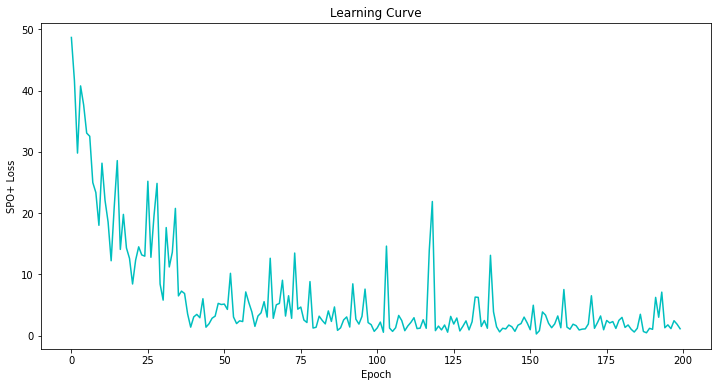

In [44]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

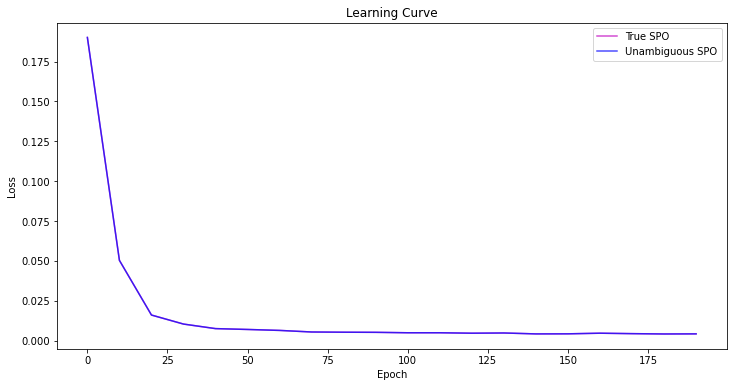

In [45]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [46]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.43%
Normalized unambiguous SPO Loss: 0.43%


In [47]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 5.00, 4.00, 5.00, 5.00, 4.00, 3.00, 5.00, 5.00, 3.00, 3.00, 4.00, 4.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 5.00, 3.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 4.00, 3.00, 5.00, 3.00, 3.00, 5.00, 3.00, 3.00, 5.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 4.00
    Pred cost: 5.88, 4.38, 5.01, 5.66, 4.38, 2.57, 5.00, 5.36, 2.17, 3.61, 4.30, 4.93, 4.30, 3.68, 3.47, 4.88, 4.63, 5.23, 5.44, 2.29, 3.24, 3.90, 2.72, 5.16, 4.70, 4.74, 4.57, 2.95, 5.00, 2.73, 2.36, 4.71, 2.96, 3.27, 4.33, 4.77, 2.12, 5.19, 2.26, 3.07, 5.18, 2.55, 4.58, 2.20, 4.31, 4.34, 2.35, 3.93
    True sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, True obj: 33.00
    Pred sol: 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, 0, -0, -0, 0, -0, -0, -0, -0, 1, -0, 1, 0, -0, -0, -0, -0, 0, -0, -0, -0, 0, -0, 1, -0, -0, 1, -0, 0, -0, -0, 1, -0, -0, Pred obj: 33.00

Sa

## SPO+ Rel 

In [48]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [49]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [50]:
# init SPO+ loss
criterion = spo.func.SPOPlus(ks_model_rel, processes=4)

Num of cores: 4


In [51]:
# train model
num_epochs = 200
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  27.1617, True SPO Loss: 16.6544%, Unambiguous SPO Loss: 16.6544%
Epoch  20, Loss:  24.7262, True SPO Loss:  3.6728%, Unambiguous SPO Loss:  3.6729%
Epoch  30, Loss:  20.4763, True SPO Loss:  1.2933%, Unambiguous SPO Loss:  1.2933%
Epoch  40, Loss:   6.2842, True SPO Loss:  0.7824%, Unambiguous SPO Loss:  0.7824%
Epoch  50, Loss:   2.7401, True SPO Loss:  0.7341%, Unambiguous SPO Loss:  0.7341%
Epoch  60, Loss:   4.2051, True SPO Loss:  0.6628%, Unambiguous SPO Loss:  0.6628%
Epoch  70, Loss:   1.7517, True SPO Loss:  0.6306%, Unambiguous SPO Loss:  0.6306%
Epoch  80, Loss:   2.9560, True SPO Loss:  0.5155%, Unambiguous SPO Loss:  0.5155%
Epoch  90, Loss:   1.5266, True SPO Loss:  0.5339%, Unambiguous SPO Loss:  0.5339%
Epoch 100, Loss:   1.2909, True SPO Loss:  0.4810%, Unambiguous SPO Loss:  0.4810%
Epoch 110, Loss:   1.3421, True SPO Loss:  0.4464%, Unambiguous SPO Loss:  0.4464%
Epoch 120, Loss:   1.6466, True SPO Loss:  0.4695%, Unambiguous SPO Loss:  0.4695%
Epoc

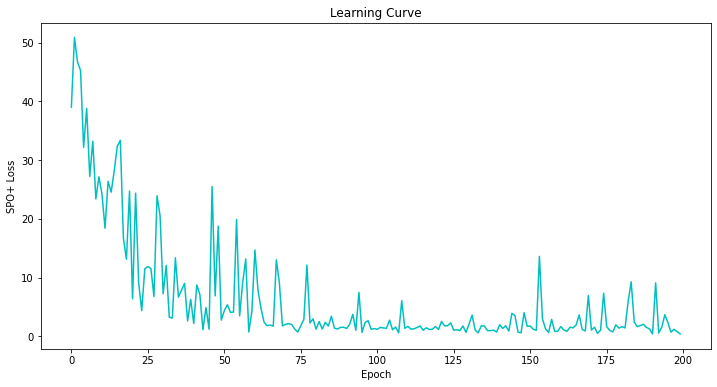

In [52]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

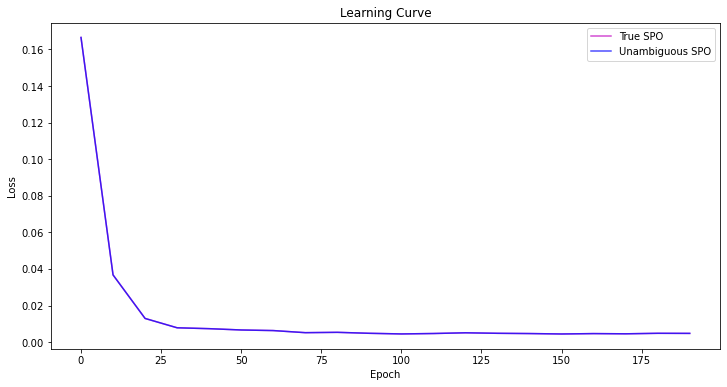

In [53]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [54]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.48%
Normalized unambiguous SPO Loss: 0.48%


In [55]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 5.00, 4.00, 5.00, 5.00, 4.00, 3.00, 5.00, 5.00, 3.00, 3.00, 4.00, 4.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 5.00, 3.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 4.00, 3.00, 5.00, 3.00, 3.00, 5.00, 3.00, 3.00, 5.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 4.00
    Pred cost: 6.09, 4.64, 5.24, 6.44, 4.89, 2.76, 5.52, 5.78, 2.29, 3.82, 4.81, 4.99, 4.62, 3.79, 3.77, 5.54, 4.96, 5.51, 6.05, 2.94, 3.76, 4.47, 3.98, 5.57, 5.36, 5.08, 4.97, 3.33, 5.87, 3.08, 2.30, 4.91, 4.01, 3.44, 4.69, 5.48, 2.53, 5.48, 2.36, 3.63, 5.43, 2.83, 4.98, 2.77, 4.75, 4.90, 2.60, 5.23
    True sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, True obj: 33.00
    Pred sol: 1, -0, -0, -0, 0, -0, -0, -0, -0, 1, -0, -0, 0, -0, -0, -0, 0, -0, 0, -0, -0, -0, -0, 1, 0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, 0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, Pred obj: 33.00

Sa

## Black-Box

In [56]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [57]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-3)

In [58]:
# set loss
bb = spo.func.blackboxOpt(ks_model, lambd=10, processes=4)
criterion = nn.L1Loss()

Num of cores: 4


In [59]:
# train model
num_epochs = 200
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   5.2500, True SPO Loss: 16.3782%, Unambiguous SPO Loss: 16.3782%
Epoch  20, Loss:   2.0000, True SPO Loss:  4.9777%, Unambiguous SPO Loss:  4.9777%
Epoch  30, Loss:   1.1250, True SPO Loss:  2.1218%, Unambiguous SPO Loss:  2.1218%
Epoch  40, Loss:   0.2500, True SPO Loss:  1.3923%, Unambiguous SPO Loss:  1.3923%
Epoch  50, Loss:   0.2500, True SPO Loss:  1.1230%, Unambiguous SPO Loss:  1.1230%
Epoch  60, Loss:   0.3750, True SPO Loss:  0.9504%, Unambiguous SPO Loss:  0.9504%
Epoch  70, Loss:   0.0000, True SPO Loss:  0.8147%, Unambiguous SPO Loss:  0.8147%
Epoch  80, Loss:   0.2500, True SPO Loss:  0.7134%, Unambiguous SPO Loss:  0.7134%
Epoch  90, Loss:   0.5000, True SPO Loss:  0.6720%, Unambiguous SPO Loss:  0.6720%
Epoch 100, Loss:   0.1250, True SPO Loss:  0.6490%, Unambiguous SPO Loss:  0.6490%
Epoch 110, Loss:   0.1250, True SPO Loss:  0.6651%, Unambiguous SPO Loss:  0.6651%
Epoch 120, Loss:   0.0000, True SPO Loss:  0.5684%, Unambiguous SPO Loss:  0.5684%
Epoc

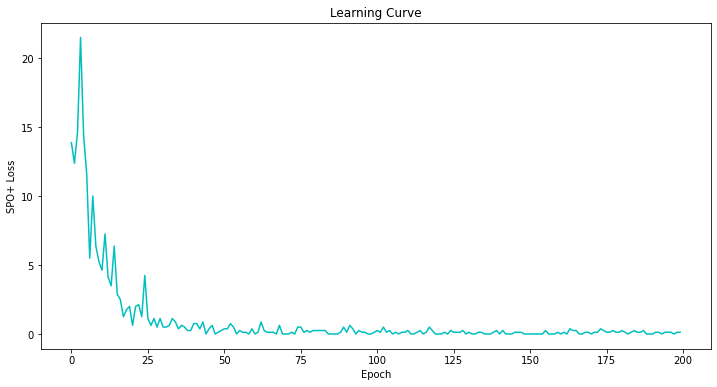

In [60]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

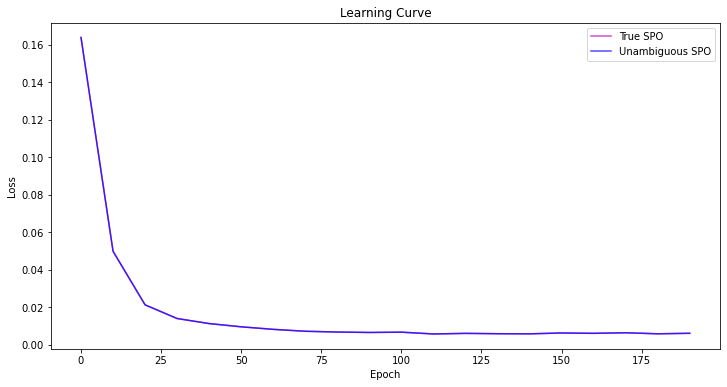

In [61]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [62]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.61%
Normalized unambiguous SPO Loss: 0.61%


In [63]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 5.00, 4.00, 5.00, 5.00, 4.00, 3.00, 5.00, 5.00, 3.00, 3.00, 4.00, 4.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 5.00, 3.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 4.00, 3.00, 5.00, 3.00, 3.00, 5.00, 3.00, 3.00, 5.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 4.00
    Pred cost: 0.40, 0.20, 0.11, 0.21, 0.23, 0.11, 0.16, 0.21, -0.12, 0.17, 0.23, -0.08, 0.13, 0.08, 0.09, 0.25, -0.18, 0.23, 0.29, -0.25, 0.06, 0.17, -0.13, 0.34, 0.19, 0.31, 0.28, 0.11, 0.04, 0.02, -0.40, 0.27, -0.13, -0.08, 0.21, 0.16, -0.18, 0.35, -0.05, 0.07, 0.36, -0.05, 0.24, -0.15, -0.07, 0.23, -0.09, 0.04
    True sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, True obj: 33.00
    Pred sol: 1, -0, -0, -0, -0, -0, -0, -0, 0, 1, -0, 0, -0, -0, -0, 0, 0, -0, -0, 0, -0, -0, 0, 1, -0, 1, -0, -0, -0, -0, 0, -0, 0, 0, -0, -0, 0, 1, 0, -0, 1, 0, -0, 0, 0, 1, 0, -0, Pred obj: 33.0